# Imports and File Upload

In [1]:
# Install required libraries
!pip install torchviz
!pip install transformers torch torchvision

# General-purpose libraries
import os
import random
from pathlib import Path
from typing import Literal

# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch and related utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchviz import make_dot

# HuggingFace Transformers
from transformers import ViTModel, ViTImageProcessor

# Scikit-learn for splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Keras utilities (used for image inspection or export)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
df_original = pd.read_csv("/content/drive/MyDrive/ML_Files/coughvid_v3.csv")
# Adjust the path above if your CSV is stored elsewhere

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

# Producing and Saving 600x240 Images
### Only Necessary to Run if Images are not Saved on Your Local Machine

In [ ]:
def load_images_with_filenames(folder_path: str,
                               target_size: tuple[int,int] = (128,128),
                               img_extensions: tuple[str,...] = ('.png','.jpg','.jpeg','.bmp','.gif')) \
                               -> np.ndarray:
    """
    Scans `folder_path` for image files, loads & resizes them, and returns
    a structured NumPy array with:
      - 'filename': the image file name (string)
      - 'image':    the image tensor (H x W x 3, dtype float32)
    """
    # Gather valid file names
    filenames = [f for f in os.listdir(folder_path)
                 if f.lower().endswith(img_extensions)]
    N = len(filenames)
    H, W = target_size

    # Define a structured dtype: unicode filename + image array
    dtype = np.dtype([
        ('filename', f'U{max(len(f) for f in filenames)}'),
        ('image',     np.float32,      (H, W, 3))
    ])

    # Allocate the array and fill it
    data = np.empty(N, dtype=dtype)
    for i, fname in enumerate(filenames):
        img_path = os.path.join(folder_path, fname)
        img = load_img(img_path, target_size=target_size)   # PIL Image
        arr = img_to_array(img) / 255.0                     # normalize 0–1
        data[i] = (fname, arr)

    return data

# folder = '/content/all_images_combined'
# dataset = load_images_with_filenames(folder, target_size=(600,240))

# print(dataset[9]['filename'])
# print(dataset[9]['image'].shape)

def save_image_dataset(data: np.ndarray, file_path: str):
    """
    Saves a structured NumPy array (with 'filename' & 'image' fields) to disk.
    - data: the structured array you got from load_images_with_filenames()
    - file_path: where to write, e.g. 'dataset.npy' or full/path/to/dataset.npy
    """
    # Ensure directory exists
    os.makedirs(os.path.dirname(file_path) or '.', exist_ok=True)
    # Save in NumPy's .npy format
    np.save(file_path, data)
    print(f"Saved {data.shape[0]} entries to {file_path!r}")

# save_image_dataset(dataset, "/Users/theodoreutomo/cough-audio-predictions/YuanDataProcessing/images_dataset_600x240.npy")
# Also make sure to change the file path to save it to where you want it to be saved in your local device

# Loading and Preprocessing Data

In [2]:
!unzip /content/drive/MyDrive/ML_Files/images_dataset_600x240.npy.zip
dataset = np.load("/content/images_dataset_600x240.npy")

print(df_original.info())
print(df_original.head())

def merge_image_array_with_df(
    df: pd.DataFrame,
    image_data: np.ndarray,
    df_filename_col: str = 'file_name',
    image_filename_field: str = 'filename',
    image_array_field: str = 'image',
    how: Literal['left','inner','right','outer'] = 'left'
) -> pd.DataFrame:
    """
    Merge a pandas DataFrame with a structured NumPy array of images,
    matching on filename stems (no extension) on both sides.
    """

    # Copy df and create a 'stem' column by stripping extensions
    df2 = df.copy()
    df2['__stem'] = df2[df_filename_col].apply(lambda fn: Path(fn).stem)

    # Build a DataFrame from your structured array and strip its extensions
    df_img = pd.DataFrame({
        image_filename_field: image_data[image_filename_field],
        image_array_field:     list(image_data[image_array_field])
    })
    df_img['__stem'] = df_img[image_filename_field].apply(lambda fn: Path(fn).stem)

    # Merge on the stems
    merged = pd.merge(
        df2,
        df_img[['__stem', image_array_field]],
        on='__stem',
        how=how
    )

    # Drop the helper column
    merged = merged.drop(columns=['__stem'])
    return merged

merged_df = merge_image_array_with_df(df_original, dataset)
print(merged_df.info())
print("Images attached:", merged_df['image'].notna().sum(), "out of", len(merged_df))

clean_df = merged_df.dropna(subset=['image', 'status']).reset_index(drop=True)

print(f"Kept {len(clean_df)} rows with both an image and a status.")
print(clean_df.info())

clean_df.drop(columns=['latitude', 'longitude', 'datetime', 'age'], inplace=True)
print(clean_df.info())

clean_df.drop(columns=['file_name', 'audio_name'], inplace=True)
clean_df.info()
"""
At this point in the code this is the full image dataset that has metadata, the datasets below are just manipulations of the
dataset above. If anything happens to data manipulations or anything refer to this dataset above.
"""

# One Hot Encoding Dataset to Trinary Values (healthy, covid, symptomatic)
clean_df_ohe = pd.get_dummies(
    clean_df,
    columns=['gender', 'respiratory_condition', 'fever_muscle_pain'],
    prefix=['gender', 'resp', 'fever'],
    drop_first=False
)

print(clean_df_ohe.info())
print(clean_df_ohe['status'].unique())

clean_df_ohe = pd.get_dummies(
    clean_df,
    columns=['gender', 'respiratory_condition', 'fever_muscle_pain', 'status'],
    prefix=['gender', 'resp', 'fever', 'status'],
    drop_first=False
)

print(clean_df_ohe.head())

# clean_df_ohe.to_pickle('/Users/theodoreutomo/cough-audio-predictions/tabular_form/clean_df_ohe_600x240.pkl')
# Make sure to modify file path to where you want to store this in local device

# Balancing Datasets so that All Values are Equal
# Compute class sizes via the one-hot columns
n_healthy     = clean_df_ohe['status_healthy'].sum()
n_symptomatic = clean_df_ohe['status_symptomatic'].sum()
n_covid       = clean_df_ohe['status_COVID-19'].sum()

min_n = int(min(n_healthy, n_symptomatic, n_covid))
print(f"Sampling {min_n} rows from each status class…")

# Sample that many from each group
df_healthy     = clean_df_ohe[clean_df_ohe['status_healthy']     == 1].sample(n=min_n, random_state=42)
df_symptomatic = clean_df_ohe[clean_df_ohe['status_symptomatic'] == 1].sample(n=min_n, random_state=42)
df_covid       = clean_df_ohe[clean_df_ohe['status_COVID-19']    == 1].sample(n=min_n, random_state=42)

# Concatenate, shuffle, reset index
balanced_df_ohe = pd.concat([df_healthy, df_symptomatic, df_covid]) \
                     .sample(frac=1, random_state=42) \
                     .reset_index(drop=True)

counts = {
    'healthy':     balanced_df_ohe['status_healthy'].sum(),
    'symptomatic': balanced_df_ohe['status_symptomatic'].sum(),
    'COVID-19':    balanced_df_ohe['status_COVID-19'].sum(),
}
print("Balanced class counts:", counts)
print("Balanced DF shape:", balanced_df_ohe.shape)

# balanced_df_ohe.to_pickle('/Users/theodoreutomo/cough-audio-predictions/tabular_form/balanced_df_ohe_600x240.pkl')

# Modifying Original clean_df to convert symptomatic/covid into one binary class
print(clean_df.info())

clean_df_binary = pd.get_dummies(
    clean_df,
    columns=['gender', 'respiratory_condition', 'fever_muscle_pain'],
    prefix=['gender', 'resp', 'fever'],
    drop_first=False
)

clean_df_binary.info()
print(clean_df_binary['status'].unique())

clean_df_binary['status_binary'] = (
    clean_df_binary['status'] != 'healthy'
).astype(int)

# Is a 0 if healthy, 1 if symptomatic/covid

print(clean_df_binary.head())

print(
    clean_df_binary
        .groupby('status')
        .status_binary
        .unique()
)

print(clean_df_binary.info())
print(clean_df_binary.head())

Archive:  /content/drive/MyDrive/ML_Files/images_dataset_600x240.npy.zip
  inflating: images_dataset_600x240.npy  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34434 entries, 0 to 34433
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datetime               34434 non-null  object 
 1   cough_detected         34434 non-null  float64
 2   latitude               19431 non-null  float64
 3   longitude              19431 non-null  float64
 4   age                    19396 non-null  float64
 5   gender                 20664 non-null  object 
 6   respiratory_condition  20664 non-null  object 
 7   fever_muscle_pain      20664 non-null  object 
 8   status                 20664 non-null  object 
 9   file_name              34434 non-null  object 
 10  audio_name             34434 non-null  object 
dtypes: float64(4), object(7)
memory usage: 2.9+ MB
None
                           datetime  cough_

# Model For Binary Values

Image size: 600×240, metadata dim: 8
Saved architecture diagram → cnn_with_meta_binary.png
Epoch 01 | Train loss=0.5511, acc=0.751 | Val   loss=0.5196, acc=0.757
Epoch 02 | Train loss=0.5326, acc=0.756 | Val   loss=0.5208, acc=0.759
Epoch 03 | Train loss=0.5266, acc=0.756 | Val   loss=0.5155, acc=0.759
Epoch 04 | Train loss=0.5284, acc=0.756 | Val   loss=0.5163, acc=0.753
Epoch 05 | Train loss=0.5270, acc=0.756 | Val   loss=0.5162, acc=0.754
Epoch 06 | Train loss=0.5262, acc=0.756 | Val   loss=0.5174, acc=0.753
Epoch 07 | Train loss=0.5273, acc=0.756 | Val   loss=0.5167, acc=0.760
Epoch 08 | Train loss=0.5275, acc=0.754 | Val   loss=0.5176, acc=0.754
Epoch 09 | Train loss=0.5257, acc=0.756 | Val   loss=0.5168, acc=0.760
Epoch 10 | Train loss=0.5254, acc=0.759 | Val   loss=0.5169, acc=0.755
Epoch 11 | Train loss=0.5263, acc=0.753 | Val   loss=0.5181, acc=0.758
Epoch 12 | Train loss=0.5257, acc=0.755 | Val   loss=0.5184, acc=0.758
Epoch 13 | Train loss=0.5249, acc=0.758 | Val   loss=0.51

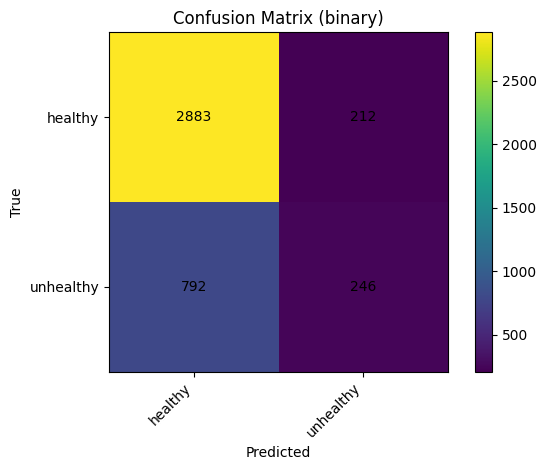

In [3]:
# Dropping status column
clean_df_binary.drop(columns=['status'],
              inplace=True)

# split
train_df, val_df = train_test_split(
    clean_df_binary,
    test_size=0.2,
    stratify=clean_df_binary['status_binary'],
    random_state=42
)

# 2) Dataset including metadata
class CoughDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.images = df['image'].values
        self.labels = df['status_binary'].values.astype(np.int64)
        # metadata columns
        meta_cols = [
            'cough_detected',
            'gender_female','gender_male','gender_other',
            'resp_False','resp_True',
            'fever_False','fever_True'
        ]
        self.meta = df[meta_cols].values.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img   = torch.from_numpy(self.images[idx]).permute(2,0,1)
        meta  = torch.tensor(self.meta[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            img = self.transform(img)
        return img, meta, label

# 3) DataLoaders
BATCH_SIZE = 32
train_ds = CoughDataset(train_df)
val_ds   = CoughDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 4) Inspect shapes
imgs, metas, labels = next(iter(train_loader))
_, _, H, W = imgs.shape
n_meta = metas.shape[1]
print(f"Image size: {H}×{W}, metadata dim: {n_meta}")

# 5) Define binary CNN + metadata model
class CNNWithMetaBinary(nn.Module):
    def __init__(self, img_h, img_w, n_meta):
        super().__init__()
        # image branch
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64,128, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        feat_dim = 128 * (img_h//8) * (img_w//8)
        self.fc_img  = nn.Linear(feat_dim, 128)
        # metadata branch
        self.fc_meta = nn.Linear(n_meta, 32)
        # combined classifier (2 classes)
        self.dropout = nn.Dropout(0.5)
        self.fc_out  = nn.Linear(128 + 32, 2)

    def forward(self, x, meta):
        x = F.relu(self.conv1(x)); x = self.pool(x)
        x = F.relu(self.conv2(x)); x = self.pool(x)
        x = F.relu(self.conv3(x)); x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_img(x))
        m = F.relu(self.fc_meta(meta))
        combined = torch.cat([x, m], dim=1)
        combined = self.dropout(combined)
        return self.fc_out(combined)

# 6) Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNWithMetaBinary(H, W, n_meta).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 1) Create one dummy “batch” matching your real inputs
dummy_imgs = torch.randn(1, 3, H, W, device=device)
dummy_meta = torch.randn(1, n_meta,     device=device)

# 2) Forward-pass through the model
y = model(dummy_imgs, dummy_meta)

# 3) Build & save the graph
dot = make_dot(
    y,
    params=dict(model.named_parameters()),
    show_attrs=False,
    show_saved=False
)
# dot.format = 'png'                    # output format
# dot.render('cnn_with_meta_binary')    # writes cnn_with_meta_binary.png

print("Saved architecture diagram → cnn_with_meta_binary.png")

# 7) Train
EPOCHS = 20
best_val_acc = 0.0

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = correct = total = 0
    for imgs, metas, labels in train_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, metas)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)
    train_loss, train_acc = train_loss/total, correct/total

    model.eval()
    val_loss = correct = total = 0
    with torch.no_grad():
        for imgs, metas, labels in val_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            outputs = model(imgs, metas)
            loss = criterion(outputs, labels)
            val_loss += loss.item()*imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    val_loss, val_acc = val_loss/total, correct/total

    print(f"Epoch {epoch:02d} | "
          f"Train loss={train_loss:.4f}, acc={train_acc:.3f} | "
          f"Val   loss={val_loss:.4f}, acc={val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_binary_cnn_with_meta.pt")

print(f"Best val acc: {best_val_acc:.3f}")

# 8) Evaluate
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, metas, labels in val_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        outputs = model(imgs, metas)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds, target_names=['healthy','unhealthy']))

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
classes = ['healthy','unhealthy']
ax.set(xticks=np.arange(len(classes)), yticks=np.arange(len(classes)),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted', ylabel='True',
       title='Confusion Matrix (binary)')
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i,j], ha="center", va="center")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Model For Balanced Data (Trinary Values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3945 entries, 0 to 3944
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cough_detected      3945 non-null   float64
 1   image               3945 non-null   object 
 2   gender_female       3945 non-null   bool   
 3   gender_male         3945 non-null   bool   
 4   gender_other        3945 non-null   bool   
 5   resp_False          3945 non-null   bool   
 6   resp_True           3945 non-null   bool   
 7   fever_False         3945 non-null   bool   
 8   fever_True          3945 non-null   bool   
 9   status_COVID-19     3945 non-null   bool   
 10  status_healthy      3945 non-null   bool   
 11  status_symptomatic  3945 non-null   bool   
dtypes: bool(10), float64(1), object(1)
memory usage: 100.3+ KB
None
Epoch 01  Train loss=1.2010, acc=0.379  Val loss=1.0792, acc=0.430
Epoch 02  Train loss=1.0678, acc=0.430  Val loss=1.0623, acc=0.445
Epoc

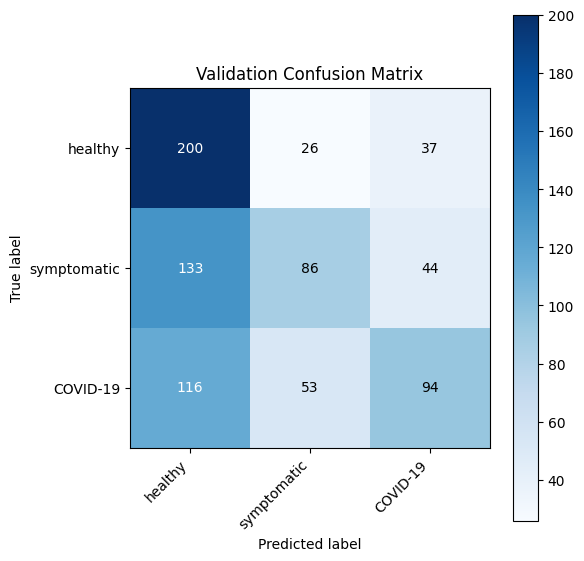

In [4]:
print(balanced_df_ohe.info())

# create a single trinary label:
#   0 = healthy, 1 = symptomatic, 2 = COVID-19
status_cols = ['status_healthy','status_symptomatic','status_COVID-19']
balanced_df_ohe['label'] = np.argmax(balanced_df_ohe[status_cols].values, axis=1)

# drop the original one-hot status columns
balanced_df_ohe.drop(columns=status_cols, inplace=True)

# split into train / validation
train_df, val_df = train_test_split(
    balanced_df_ohe,
    test_size=0.2,
    stratify=balanced_df_ohe['label'],
    random_state=42
)


# === 2) Dataset class including metadata ===

class CoughDataset(Dataset):
    def __init__(self, df, transform=None):
        self.images = df['image'].values
        self.labels = df['label'].values.astype(np.int64)
        meta_cols = [
            'cough_detected',
            'gender_female','gender_male','gender_other',
            'resp_False','resp_True',
            'fever_False','fever_True'
        ]
        self.meta = df[meta_cols].values.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img   = torch.from_numpy(self.images[idx]).permute(2,0,1)   # (H,W,3)->(3,H,W)
        meta  = torch.tensor(self.meta[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            img = self.transform(img)
        return img, meta, label

# create loaders
BATCH_SIZE = 32
train_loader = DataLoader(CoughDataset(train_df), batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(CoughDataset(val_df),   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# === 3) Define the CNN+metadata model ===

import torch.nn as nn
import torch.nn.functional as F

# peek a batch to get image dims and metadata size
imgs, metas, _ = next(iter(train_loader))
_, _, H, W = imgs.shape
n_meta = metas.shape[1]

class CNNWithMeta3(nn.Module):
    def __init__(self, img_h, img_w, n_meta, num_classes=3):
        super().__init__()
        # image branch
        self.conv1 = nn.Conv2d(3,  32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64,128, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        feat_dim = 128 * (img_h//8) * (img_w//8)
        self.fc_img  = nn.Linear(feat_dim, 128)
        # metadata branch
        self.fc_meta = nn.Linear(n_meta, 32)
        # combined classifier
        self.dropout = nn.Dropout(0.5)
        self.fc_out  = nn.Linear(128 + 32, num_classes)

    def forward(self, x, meta):
        x = F.relu(self.conv1(x)); x = self.pool(x)
        x = F.relu(self.conv2(x)); x = self.pool(x)
        x = F.relu(self.conv3(x)); x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_img(x))
        m = F.relu(self.fc_meta(meta))
        combined = torch.cat([x, m], dim=1)
        combined = self.dropout(combined)
        return self.fc_out(combined)


# === 4) Training setup ===

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNWithMeta3(H, W, n_meta).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



EPOCHS = 20
best_val_acc = 0.0

for epoch in range(1, EPOCHS+1):
    # — train —
    model.train()
    train_loss = train_correct = train_total = 0
    for imgs, metas, labels in train_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, metas)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss   += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total   += labels.size(0)

    train_loss /= train_total
    train_acc  = train_correct / train_total

    # — validate —
    model.eval()
    val_loss = val_correct = val_total = 0
    with torch.no_grad():
        for imgs, metas, labels in val_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            outputs = model(imgs, metas)
            loss = criterion(outputs, labels)

            val_loss    += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total   += labels.size(0)

    val_loss /= val_total
    val_acc  = val_correct / val_total

    print(f"Epoch {epoch:02d}  Train loss={train_loss:.4f}, acc={train_acc:.3f}  "
          f"Val loss={val_loss:.4f}, acc={val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_trinary_cnn_with_meta.pt")

print(f"Best validation acc: {best_val_acc:.3f}")

model.load_state_dict(
    torch.load("best_trinary_cnn_with_meta.pt", map_location=device)
)
model.to(device).eval()

# 2) Run model on validation set
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, metas, labels in val_loader:
        imgs, metas = imgs.to(device), metas.to(device)
        outputs = model(imgs, metas)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3) Print classification report
print("Classification Report:\n")
print(classification_report(
    all_labels,
    all_preds,
    target_names=['healthy','symptomatic','COVID-19'],
    digits=4
))

# 4) Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
classes = ['healthy','symptomatic','COVID-19']

# 5) Plot confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Predicted label',
    ylabel='True label',
    title='Validation Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# annotate cell counts
thresh = cm.max() / 2
for i in range(len(classes)):
    for j in range(len(classes)):
        color = "white" if cm[i,j] > thresh else "black"
        ax.text(j, i, cm[i, j], ha="center", va="center", color=color)

plt.tight_layout()
plt.show()

# Trinary Values With Focal Loss

   cough_detected                                              image  \
0          0.9761  [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...   
1          0.0217  [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...   
2          0.9886  [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...   
3          0.8499  [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...   
4          0.7665  [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...   

   gender_female  gender_male  gender_other  resp_False  resp_True  \
0           True        False         False       False       True   
1          False         True         False       False       True   
2          False         True         False        True      False   
3          False         True         False        True      False   
4          False         True         False        True      False   

   fever_False  fever_True  status_COVID-19  status_healthy  \
0         True       False            False            True   
1         True      

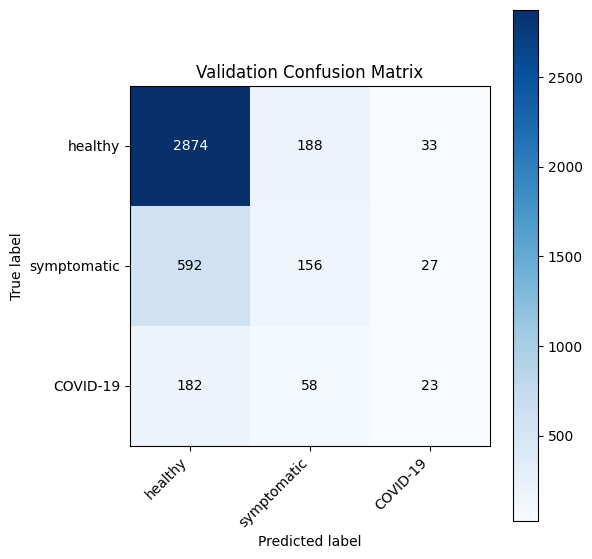

In [5]:
status_cols = ['status_healthy', 'status_symptomatic', 'status_COVID-19']
clean_df_ohe['label'] = np.argmax(clean_df_ohe[status_cols].values, axis=1)

print(clean_df_ohe.head())

train_df, val_df = train_test_split(
    clean_df_ohe,
    test_size=0.2,
    stratify=clean_df_ohe['label'],
    random_state=42
)

# 2) Dataset class
class CoughDataset(Dataset):
    def __init__(self, df, transform=None):
        self.images = df['image'].values
        self.labels = df['label'].values.astype(np.int64)
        meta_cols = [
            'cough_detected',
            'gender_female','gender_male','gender_other',
            'resp_False','resp_True',
            'fever_False','fever_True'
        ]
        self.meta = df[meta_cols].values.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img   = torch.from_numpy(self.images[idx]).permute(2,0,1)   # (H,W,3)->(3,H,W)
        meta  = torch.from_numpy(self.meta[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            img = self.transform(img)
        return img, meta, label

BATCH_SIZE = 32
train_loader = DataLoader(CoughDataset(train_df), batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(CoughDataset(val_df),   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 3) Model definition
class CNNWithMeta3(nn.Module):
    def __init__(self, img_h, img_w, n_meta, num_classes=3):
        super().__init__()
        # image branch
        self.conv1 = nn.Conv2d(3,  32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64,128, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        feat_dim = 128 * (img_h//8) * (img_w//8)
        self.fc_img  = nn.Linear(feat_dim, 128)
        # metadata branch
        self.fc_meta = nn.Linear(n_meta, 32)
        # combined classifier
        self.dropout = nn.Dropout(0.5)
        self.fc_out  = nn.Linear(128 + 32, num_classes)

    def forward(self, x, meta):
        x = F.relu(self.conv1(x)); x = self.pool(x)
        x = F.relu(self.conv2(x)); x = self.pool(x)
        x = F.relu(self.conv3(x)); x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_img(x))

        m = F.relu(self.fc_meta(meta))
        combined = torch.cat([x, m], dim=1)
        combined = self.dropout(combined)
        return self.fc_out(combined)

# 4) Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha: torch.Tensor = None, gamma: float = 2.0, reduction: str = 'mean'):
        """
        alpha: tensor of shape (num_classes,) specifying weight for each class
        gamma: focusing parameter (higher => more focus on hard examples)
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # inputs: (N, C) logits; targets: (N,) class indices
        logpt = -F.cross_entropy(inputs, targets, reduction='none')
        pt = logpt.exp()

        # standard CE loss per sample, but with class weights:
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')

        # focal scaling:
        focal_term = (1 - pt) ** self.gamma
        loss = focal_term * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# 5) Setup device, model, criterion, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# peek a batch to infer dimensions
imgs, metas, _ = next(iter(train_loader))
_, _, H, W = imgs.shape
n_meta = metas.shape[1]

model = CNNWithMeta3(H, W, n_meta).to(device)

# give symptomatic (+1) and COVID-19 (+2) double weight vs healthy:
alpha = torch.tensor([1.0, 2.0, 4.0], device=device)
criterion = FocalLoss(alpha=alpha, gamma=2.0, reduction='mean')

optimizer = optim.Adam(model.parameters(), lr=1e-3)


# 6) Training & validation loop
EPOCHS = 20
best_val_acc = 0.0

for epoch in range(1, EPOCHS+1):
    # — train —
    model.train()
    train_loss = train_correct = train_total = 0
    for imgs, metas, labels in train_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, metas)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss   += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total   += labels.size(0)

    train_loss /= train_total
    train_acc  = train_correct / train_total

    # — validate —
    model.eval()
    val_loss = val_correct = val_total = 0
    with torch.no_grad():
        for imgs, metas, labels in val_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            outputs = model(imgs, metas)
            loss = criterion(outputs, labels)

            val_loss    += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total   += labels.size(0)

    val_loss /= val_total
    val_acc  = val_correct / val_total

    print(f"Epoch {epoch:02d}  "
          f"Train loss={train_loss:.4f}, acc={train_acc:.3f}  "
          f"Val loss={val_loss:.4f}, acc={val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_trinary_cnn_with_meta.pt")

print(f"Best validation acc: {best_val_acc:.3f}")

# 7) Load best model & evaluate on validation set
model.load_state_dict(torch.load("best_trinary_cnn_with_meta.pt", map_location=device))
model.to(device).eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, metas, labels in val_loader:
        imgs, metas = imgs.to(device), metas.to(device)
        outputs = model(imgs, metas)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:\n")
print(classification_report(all_labels, all_preds,
                            target_names=['healthy','symptomatic','COVID-19'],
                            digits=4))

cm = confusion_matrix(all_labels, all_preds)
classes = ['healthy','symptomatic','COVID-19']

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Predicted label',
    ylabel='True label',
    title='Validation Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
thresh = cm.max() / 2
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i,j] > thresh else "black")
plt.tight_layout()
plt.show()

# Focal Loss Binary

Image size: 600×240, metadata dim: 8
Epoch 01 | Train loss=0.0624, acc=0.495 | Val   loss=0.0557, acc=0.581
Epoch 02 | Train loss=0.0567, acc=0.574 | Val   loss=0.0555, acc=0.626
Epoch 03 | Train loss=0.0566, acc=0.588 | Val   loss=0.0555, acc=0.648
Epoch 04 | Train loss=0.0564, acc=0.598 | Val   loss=0.0554, acc=0.587
Epoch 05 | Train loss=0.0564, acc=0.579 | Val   loss=0.0554, acc=0.648
Epoch 06 | Train loss=0.0563, acc=0.583 | Val   loss=0.0554, acc=0.740
Epoch 07 | Train loss=0.0563, acc=0.593 | Val   loss=0.0554, acc=0.579
Epoch 08 | Train loss=0.0563, acc=0.569 | Val   loss=0.0553, acc=0.644
Epoch 09 | Train loss=0.0563, acc=0.575 | Val   loss=0.0555, acc=0.579
Epoch 10 | Train loss=0.0563, acc=0.571 | Val   loss=0.0553, acc=0.631
Epoch 11 | Train loss=0.0562, acc=0.587 | Val   loss=0.0554, acc=0.579
Epoch 12 | Train loss=0.0562, acc=0.573 | Val   loss=0.0555, acc=0.661
Epoch 13 | Train loss=0.0561, acc=0.590 | Val   loss=0.0553, acc=0.651
Epoch 14 | Train loss=0.0563, acc=0.594 

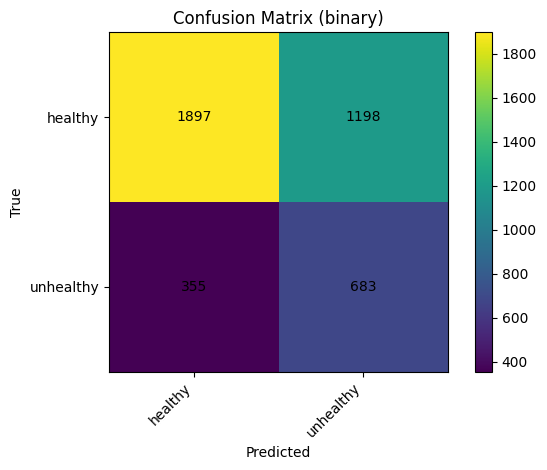

In [6]:
train_df, val_df = train_test_split(
    clean_df_binary,
    test_size=0.2,
    stratify=clean_df_binary['status_binary'],
    random_state=42
)
class FocalLoss(nn.Module):
    """
    Focal Loss for multi-class (here binary) classification.
    FL(pt) = - α_t * (1-pt)^γ * log(pt)
    where α_t is the weight for the true class.
    """
    def __init__(self, alpha: list[float] = [0.25, 0.75], gamma: float = 2.0, reduction: str = 'mean'):
        super().__init__()
        self.alpha = torch.tensor(alpha, dtype=torch.float32)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor):
        """
        inputs:  logits, shape (N, C)
        targets: integer class labels, shape (N,)
        """
        # 1) compute log-softmax
        logpt = F.log_softmax(inputs, dim=1)               # (N, C)
        pt    = logpt.exp()                                # (N, C)

        # 2) select log-probs & probs for the true class
        targets = targets.view(-1,1)                       # (N,1)
        logpt = logpt.gather(1, targets).view(-1)          # (N,)
        pt    = pt.gather(1, targets).view(-1)             # (N,)

        # 3) get α for each sample
        alpha_t = self.alpha.to(inputs.device).gather(0, targets.squeeze())

        # 4) focal loss
        loss = -alpha_t * (1 - pt)**self.gamma * logpt     # (N,)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss  # (N,)

# 2) Dataset including metadata
class CoughDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.images = df['image'].values
        self.labels = df['status_binary'].values.astype(np.int64)
        # metadata columns
        meta_cols = [
            'cough_detected',
            'gender_female','gender_male','gender_other',
            'resp_False','resp_True',
            'fever_False','fever_True'
        ]
        self.meta = df[meta_cols].values.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img   = torch.from_numpy(self.images[idx]).permute(2,0,1)
        meta  = torch.tensor(self.meta[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            img = self.transform(img)
        return img, meta, label

# 3) DataLoaders
BATCH_SIZE = 32
train_ds = CoughDataset(train_df)
val_ds   = CoughDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 4) Inspect shapes
imgs, metas, labels = next(iter(train_loader))
_, _, H, W = imgs.shape
n_meta = metas.shape[1]
print(f"Image size: {H}×{W}, metadata dim: {n_meta}")

# 5) Define binary CNN + metadata model
class CNNWithMetaBinary(nn.Module):
    def __init__(self, img_h, img_w, n_meta):
        super().__init__()
        # image branch
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64,128, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        feat_dim = 128 * (img_h//8) * (img_w//8)
        self.fc_img  = nn.Linear(feat_dim, 128)
        # metadata branch
        self.fc_meta = nn.Linear(n_meta, 32)
        # combined classifier (2 classes)
        self.dropout = nn.Dropout(0.5)
        self.fc_out  = nn.Linear(128 + 32, 2)

    def forward(self, x, meta):
        x = F.relu(self.conv1(x)); x = self.pool(x)
        x = F.relu(self.conv2(x)); x = self.pool(x)
        x = F.relu(self.conv3(x)); x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_img(x))
        m = F.relu(self.fc_meta(meta))
        combined = torch.cat([x, m], dim=1)
        combined = self.dropout(combined)
        return self.fc_out(combined)

# 6) Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNWithMetaBinary(H, W, n_meta).to(device)
criterion = FocalLoss(alpha=[0.2, 0.8], gamma=2.0, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 7) Train
EPOCHS = 20
best_val_acc = 0.0

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = correct = total = 0
    for imgs, metas, labels in train_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, metas)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)
    train_loss, train_acc = train_loss/total, correct/total

    model.eval()
    val_loss = correct = total = 0
    with torch.no_grad():
        for imgs, metas, labels in val_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            outputs = model(imgs, metas)
            loss = criterion(outputs, labels)
            val_loss += loss.item()*imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    val_loss, val_acc = val_loss/total, correct/total

    print(f"Epoch {epoch:02d} | "
          f"Train loss={train_loss:.4f}, acc={train_acc:.3f} | "
          f"Val   loss={val_loss:.4f}, acc={val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_binary_cnn_with_meta.pt")

print(f"Best val acc: {best_val_acc:.3f}")

# 8) Evaluate
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, metas, labels in val_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        outputs = model(imgs, metas)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds, target_names=['healthy','unhealthy']))

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
classes = ['healthy','unhealthy']
ax.set(xticks=np.arange(len(classes)), yticks=np.arange(len(classes)),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted', ylabel='True',
       title='Confusion Matrix (binary)')
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i,j], ha="center", va="center")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Balancing data with binary classification

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20664 entries, 0 to 20663
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cough_detected  20664 non-null  float64
 1   image           20664 non-null  object 
 2   gender_female   20664 non-null  bool   
 3   gender_male     20664 non-null  bool   
 4   gender_other    20664 non-null  bool   
 5   resp_False      20664 non-null  bool   
 6   resp_True       20664 non-null  bool   
 7   fever_False     20664 non-null  bool   
 8   fever_True      20664 non-null  bool   
 9   status_binary   20664 non-null  int64  
dtypes: bool(7), float64(1), int64(1), object(1)
memory usage: 625.7+ KB
None
status_binary
1    5188
0    5188
Name: count, dtype: int64
Image size: 600×240, metadata dim: 8
Epoch 01 | Train loss=0.7498, acc=0.512 | Val   loss=0.6882, acc=0.644
Epoch 02 | Train loss=0.6804, acc=0.599 | Val   loss=0.6657, acc=0.644
Epoch 03 | Train loss=0.6576, acc=

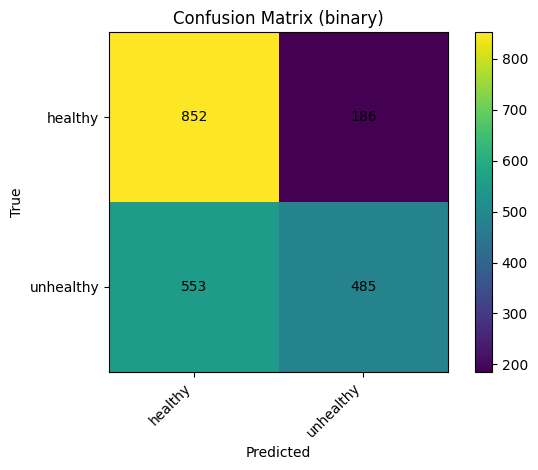

In [7]:
print(clean_df_binary.info())

counts = clean_df_binary['status_binary'].value_counts()
n_min = counts.min()

df0 = clean_df_binary[clean_df_binary['status_binary'] == 0]
df1 = clean_df_binary[clean_df_binary['status_binary'] == 1]

df0_down = df0.sample(n=n_min, random_state=42)
df1_down = df1.sample(n=n_min, random_state=42)

balanced_df_binary = pd.concat([df0_down, df1_down]) \
                .sample(frac=1, random_state=42) \
                .reset_index(drop=True)

print(balanced_df_binary['status_binary'].value_counts())

# split
train_df, val_df = train_test_split(
    balanced_df_binary,
    test_size=0.2,
    stratify=balanced_df_binary['status_binary'],
    random_state=42
)

# 2) Dataset including metadata
class CoughDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.images = df['image'].values
        self.labels = df['status_binary'].values.astype(np.int64)
        # metadata columns
        meta_cols = [
            'cough_detected',
            'gender_female','gender_male','gender_other',
            'resp_False','resp_True',
            'fever_False','fever_True'
        ]
        self.meta = df[meta_cols].values.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img   = torch.from_numpy(self.images[idx]).permute(2,0,1)
        meta  = torch.tensor(self.meta[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            img = self.transform(img)
        return img, meta, label

# 3) DataLoaders
BATCH_SIZE = 32
train_ds = CoughDataset(train_df)
val_ds   = CoughDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 4) Inspect shapes
imgs, metas, labels = next(iter(train_loader))
_, _, H, W = imgs.shape
n_meta = metas.shape[1]
print(f"Image size: {H}×{W}, metadata dim: {n_meta}")

# 5) Define binary CNN + metadata model
class CNNWithMetaBinary(nn.Module):
    def __init__(self, img_h, img_w, n_meta, num_classes=2):
        super().__init__()
        # convolutional blocks
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )

        self.block1 = conv_block(3,   32)   # 3→32
        self.block2 = conv_block(32,  64)   # 32→64
        self.block3 = conv_block(64, 128)   # 64→128
        self.block4 = conv_block(128,256)   # 128→256

        # compute flattened feature size after 4×2 pooling
        conv_out_h = img_h // (2**4)
        conv_out_w = img_w // (2**4)
        self.flatten_dim = 256 * conv_out_h * conv_out_w

        # image branch FC head
        self.fc_img = nn.Sequential(
            nn.Linear(self.flatten_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )

        # metadata branch FC head
        self.fc_meta = nn.Sequential(
            nn.Linear(n_meta, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128,  64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )

        # final classifier
        self.classifier = nn.Sequential(
            nn.Linear(256 + 64, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, meta):
        # four conv–pool blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        # flatten and image head
        x = x.view(x.size(0), -1)
        x = self.fc_img(x)

        # metadata head
        m = self.fc_meta(meta)

        # concatenate and classify
        combined = torch.cat([x, m], dim=1)
        return self.classifier(combined)

# 6) Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNWithMetaBinary(H, W, n_meta).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 7) Train
EPOCHS = 20
best_val_acc = 0.0

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = correct = total = 0
    for imgs, metas, labels in train_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, metas)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)
    train_loss, train_acc = train_loss/total, correct/total

    model.eval()
    val_loss = correct = total = 0
    with torch.no_grad():
        for imgs, metas, labels in val_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            outputs = model(imgs, metas)
            loss = criterion(outputs, labels)
            val_loss += loss.item()*imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    val_loss, val_acc = val_loss/total, correct/total

    print(f"Epoch {epoch:02d} | "
          f"Train loss={train_loss:.4f}, acc={train_acc:.3f} | "
          f"Val   loss={val_loss:.4f}, acc={val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_binary_cnn_with_meta.pt")

print(f"Best val acc: {best_val_acc:.3f}")

# 8) Evaluate
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, metas, labels in val_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        outputs = model(imgs, metas)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds, target_names=['healthy','unhealthy']))

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
classes = ['healthy','unhealthy']
ax.set(xticks=np.arange(len(classes)), yticks=np.arange(len(classes)),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted', ylabel='True',
       title='Confusion Matrix (binary)')
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i,j], ha="center", va="center")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Preliminary Transformer Model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 01 | Train Loss: 0.6746, Acc: 0.541 | Val Loss: 0.6571, Acc: 0.545
Epoch 02 | Train Loss: 0.6473, Acc: 0.611 | Val Loss: 0.6394, Acc: 0.630
Epoch 03 | Train Loss: 0.6367, Acc: 0.633 | Val Loss: 0.6366, Acc: 0.646
Epoch 04 | Train Loss: 0.6325, Acc: 0.642 | Val Loss: 0.6360, Acc: 0.630
Epoch 05 | Train Loss: 0.6289, Acc: 0.643 | Val Loss: 0.6368, Acc: 0.633
Epoch 06 | Train Loss: 0.6290, Acc: 0.645 | Val Loss: 0.6452, Acc: 0.604
Epoch 07 | Train Loss: 0.6277, Acc: 0.649 | Val Loss: 0.6372, Acc: 0.638
Epoch 08 | Train Loss: 0.6271, Acc: 0.650 | Val Loss: 0.6361, Acc: 0.626
Epoch 09 | Train Loss: 0.6235, Acc: 0.654 | Val Loss: 0.6364, Acc: 0.638
Early stopping at epoch 9
Best Validation Accuracy: 0.630
              precision    recall  f1-score   support

     healthy       0.62      0.67      0.64      1038
   unhealthy       0.64      0.59      0.61      1038

    accuracy                           0.63      2076
   macro avg       0.63      0.63      0.63      2076
weighted avg 

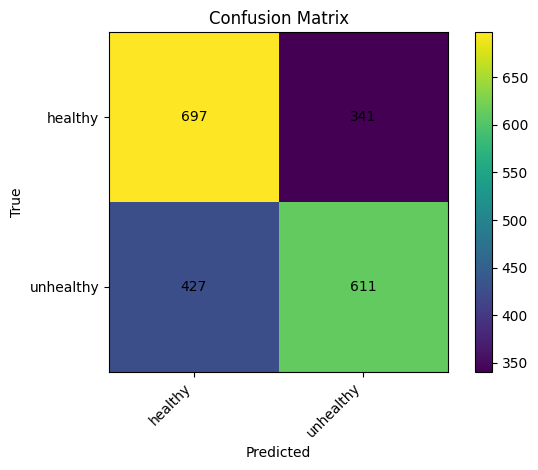

In [8]:
# Step 1: Balance and split the dataset
counts = clean_df_binary['status_binary'].value_counts()
n_min = counts.min()

df0 = clean_df_binary[clean_df_binary['status_binary'] == 0].sample(n=n_min, random_state=42)
df1 = clean_df_binary[clean_df_binary['status_binary'] == 1].sample(n=n_min, random_state=42)
balanced_df_binary = pd.concat([df0, df1]).sample(frac=1, random_state=42).reset_index(drop=True)

train_df, val_df = train_test_split(
    balanced_df_binary,
    test_size=0.2,
    stratify=balanced_df_binary['status_binary'],
    random_state=42
)

# Step 2: Dataset and image transforms
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
])

class ViTMetaDataset(Dataset):
    def __init__(self, df, augment=False):
        self.images = df['image'].values
        self.labels = df['status_binary'].values.astype(np.int64)
        self.meta = df[[
            'cough_detected',
            'gender_female', 'gender_male', 'gender_other',
            'resp_False', 'resp_True',
            'fever_False', 'fever_True'
        ]].values.astype(np.float32)
        self.augment = augment

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        img_pil = Image.fromarray((img * 255).astype('uint8')) if isinstance(img, np.ndarray) else img
        if self.augment:
            img_pil = augment_transform(img_pil)
        inputs = image_processor(images=img_pil, return_tensors="pt")
        img_tensor = inputs['pixel_values'].squeeze(0)
        meta_tensor = torch.tensor(self.meta[idx], dtype=torch.float32)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return img_tensor, meta_tensor, label_tensor

# Step 3: Dataloaders
BATCH_SIZE = 32
train_ds = ViTMetaDataset(train_df, augment=True)
val_ds   = ViTMetaDataset(val_df, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Step 4: Simplified ViT model with metadata input
class ViTWithMetaSimplified(nn.Module):
    def __init__(self, n_meta, num_classes=2, train_last_n_layers=2):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

        # Freeze most of the ViT
        for param in self.vit.parameters():
            param.requires_grad = False
        for layer in self.vit.encoder.layer[-train_last_n_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

        self.fc_meta = nn.Sequential(
            nn.Linear(n_meta, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x_img, x_meta):
        cls_token = self.vit(pixel_values=x_img).last_hidden_state[:, 0]
        meta_out = self.fc_meta(x_meta)
        combined = torch.cat([cls_token, meta_out], dim=1)
        return self.classifier(combined)

# Step 5: Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTWithMetaSimplified(n_meta=8).to(device)

vit_params = [p for p in model.vit.parameters() if p.requires_grad]
meta_params = list(model.fc_meta.parameters())
classifier_params = list(model.classifier.parameters())

optimizer = optim.Adam([
    {'params': vit_params, 'lr': 5e-6},
    {'params': meta_params, 'lr': 1e-4},
    {'params': classifier_params, 'lr': 1e-4}
])

# Use class weights to improve recall on minority class
class_weights = torch.tensor([1.0, 1.2], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, verbose=True, min_lr=1e-6)

# Step 6: Training loop with early stopping
EPOCHS = 30
best_val_acc = 0.0
best_val_loss = float('inf')
patience = 5
wait = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = correct = total = 0

    for imgs, metas, labels in train_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, metas)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total

    model.eval()
    val_loss = correct = total = 0
    with torch.no_grad():
        for imgs, metas, labels in val_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            outputs = model(imgs, metas)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = correct / total

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.3f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.3f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_with_meta_finetune.pt")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

print(f"Best Validation Accuracy: {best_val_acc:.3f}")

# Step 7: Evaluation
model.load_state_dict(torch.load("best_vit_with_meta_finetune.pt"))
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, metas, labels in val_loader:
        imgs, metas = imgs.to(device), metas.to(device)
        outputs = model(imgs, metas)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=['healthy', 'unhealthy']))
cm = confusion_matrix(all_labels, all_preds)

# Step 8: Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

classes = ['healthy', 'unhealthy']
ax.set(xticks=np.arange(len(classes)), yticks=np.arange(len(classes)),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted', ylabel='True',
       title='Confusion Matrix')

for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()